<a href="https://colab.research.google.com/github/BJToor/sep769-deep-learning-project/blob/main/DeepLearningProject_Group2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Project** - Aerial Perspective Object Detection
SEP 769 - Group 2

In [1]:
from google.colab.patches import cv2_imshow
import pandas as pd
from google.colab import drive
import tensorflow as tf
import tensorflow_datasets as tfds
drive.mount('/content/gdrive')
import cv2
import glob
import numpy as np
import os
import fnmatch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import math
tf.random.set_seed(25)


Mounted at /content/gdrive


#Constants

In [5]:
original_images_path = '/content/gdrive/Shareddrives/SEP_769/SEP_769/data/drone_data/original_images/'
original_semantic_path = '/content/gdrive/Shareddrives/SEP_769/SEP_769/data/drone_data/label_images_semantic/'
colourmap_path = "/content/gdrive/Shareddrives/SEP_769/SEP_769/class_dict_seg.csv"
rgb_masks_path = "/content/gdrive/Shareddrives/SEP_769/SEP_769/RGB_color_image_masks/RGB_color_image_masks/"
model_path = '/content/gdrive/Shareddrives/SEP_769/SEP_769/group2_vgg_segmentation.h5'
gmaps_images_path = '/content/gdrive/Shareddrives/SEP_769/SEP_769/google_maps_imgs/'


HEIGHT = 192
WIDTH = 320
EPOCHS = 40

#Functions

In [13]:
# reads images from dir, resizes and returns np array
# optional file type argument ext, and num
def images_to_array(dir, width, height, ext='.jpg', num=0):
    data = []
    files = os.listdir(dir)
    files.sort()
    if num:
        for i in range(num):
            filename = files[i]
            if filename.endswith(ext):
                img = cv2.imread(dir+filename,flags=1)
                img = cv2.resize(img, (width, height))
                data.append(img)
    else:
        for filename in files:
            if filename.endswith(ext):
                img = cv2.imread(dir+filename,flags=1)
                img = cv2.resize(img, (width, height))
                data.append(img)
    return np.array(data)

# displays a number of originals with their masks
def display_images(images):
  plt.figure(figsize=(15,10))
  for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    if len(images[i].shape) == 3 and images[i].shape[2] > 1:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(images[i]))
    else:
      # plt.imshow(images[i], cmap="gray", vmin=0, vmax=255)
      plt.imshow(images[i], cmap="gray")
  plt.show()

def labels_to_colour(label):
  colourmap = pd.read_csv(colourmap_path)
  red = np.zeros((192,320))
  green = np.zeros((192,320))
  blue = np.zeros((192,320))
  for i in range(len(label)):
    for j in range(len(label[i])):
      red[i:i+1,j:j+1] = colourmap[" r"][label[i][j]]
      green[i:i+1,j:j+1] = colourmap[" g"][label[i][j]]
      blue[i:i+1,j:j+1] = colourmap[" b"][label[i][j]]
  result = np.dstack((blue,green,red))
  # print(result.shape)
  return result

def create_mask(pred):
  mask = np.argmax(pred, axis=-1)
  mask = mask[..., np.newaxis]
  return mask

# Image Imports

In [33]:
images = images_to_array(original_images_path, width=WIDTH, height=HEIGHT, num=0)

labels = images_to_array(original_semantic_path, width=WIDTH, height=HEIGHT, ext='png', num=0)
labels = labels[:,:,:,1]

rgb_masks = images_to_array(rgb_masks_path, width=WIDTH, height=HEIGHT, ext='png', num=0)


#Data Visualization

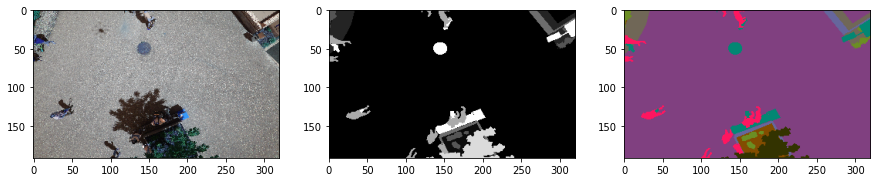

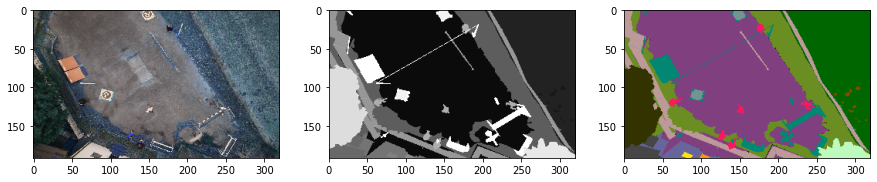

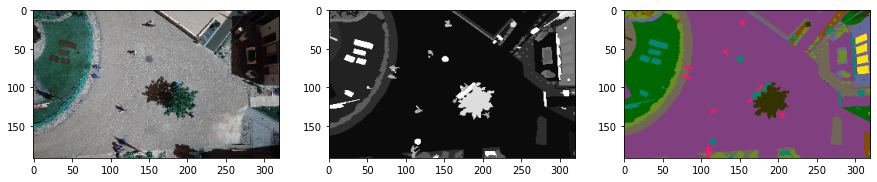

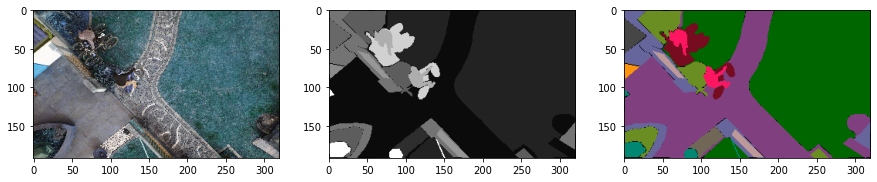

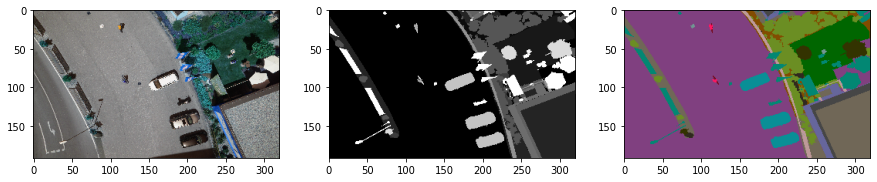

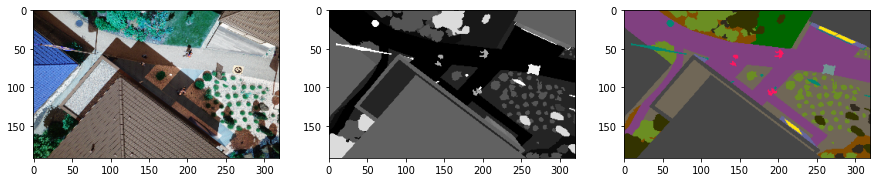

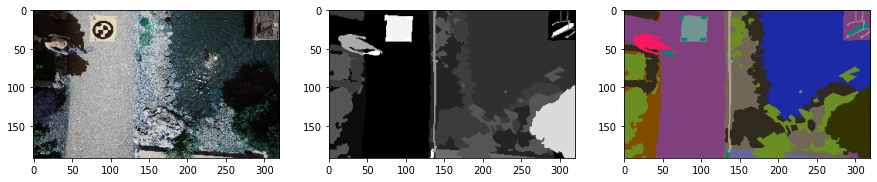

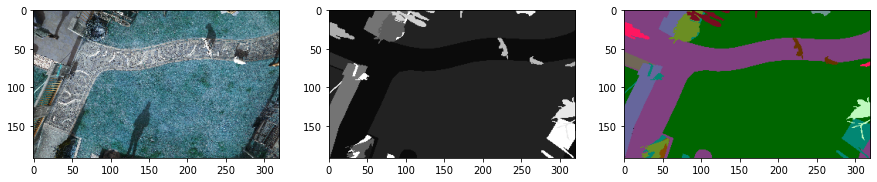

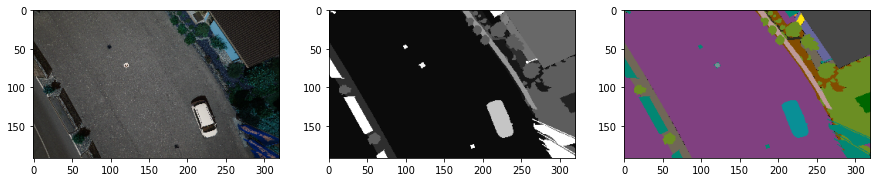

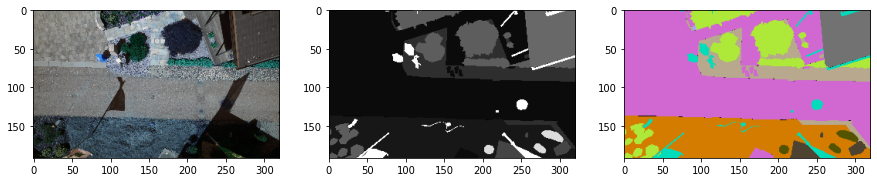

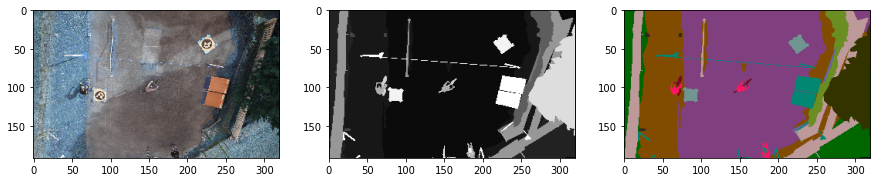

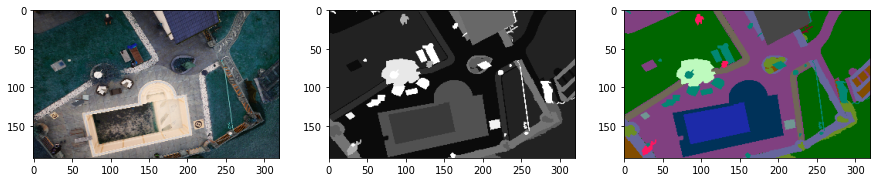

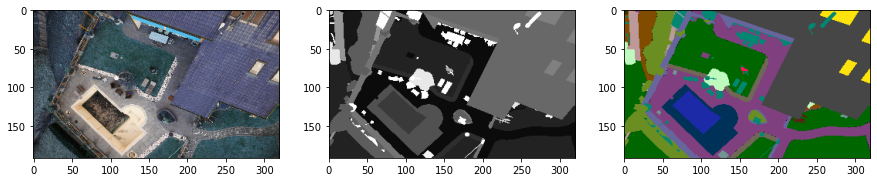

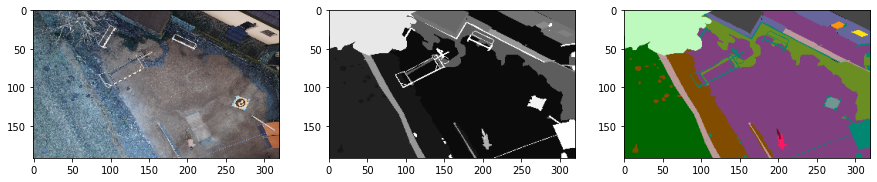

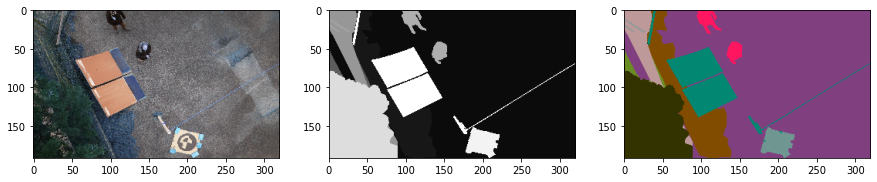

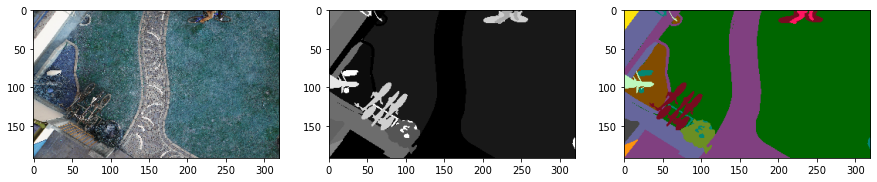

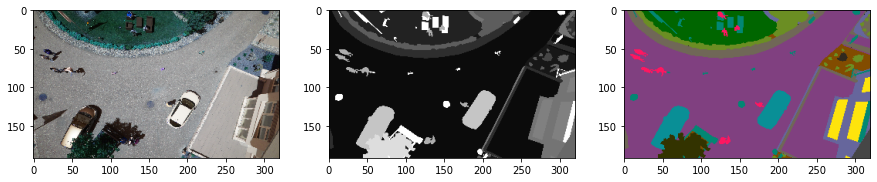

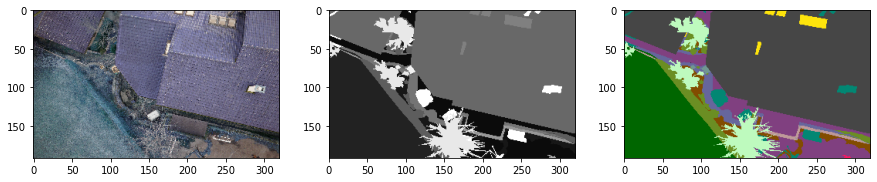

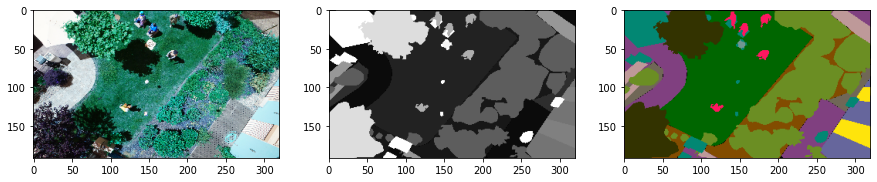

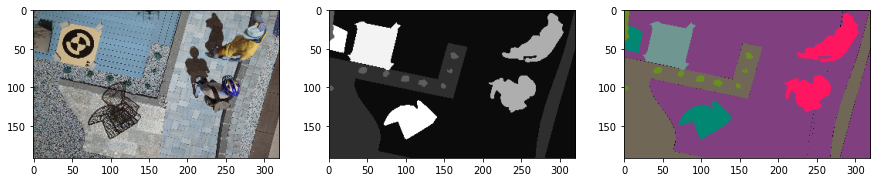

In [32]:
for i in range(20):
  display_images([images[i], labels[i], cv2.cvtColor(rgb_masks[i],cv2.COLOR_RGB2BGR)])

#Train, Test, Validation split

In [36]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1)
X_train, X_val, Y_train, Y_val, = train_test_split(x_train, y_train, test_size=0.2)
X_train = X_train / 255.0
x_test = x_test / 255.0
X_val = X_val / 255.0

print('\nTrain and Test set sizes:')
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(x_test.shape)
print(y_test.shape)



Train and Test set sizes:
(288, 192, 320, 3)
(288, 192, 320)
(72, 192, 320, 3)
(72, 192, 320)
(40, 192, 320, 3)
(40, 192, 320)


#Model Development

In [ ]:
model_input = tf.keras.Input(shape=X_train[0].shape)
transfer_model = tf.keras.applications.VGG16(include_top=False, input_tensor=model_input, weights="imagenet")
# transfer_model.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


VGG16 model

In [ ]:
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 320, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 160, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 160, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 160, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 80, 128)       0     

Extracting layers from VGG16 for encoder and creating decoder layers

In [ ]:
encoder_layers = [
               "block1_conv2",
               "block1_pool",
               "block2_conv2",
               "block2_pool",
               "block3_conv3",
               "block3_pool",
               "block4_conv3",
               "block4_pool",
               "block5_conv3",
               "block5_pool"
]

# encoder_layers = [transfer_model.get_layer(name).output for name in encoder_layers]
encoder_layers = [transfer_model.get_layer(name).output for name in encoder_layers]
encoder = tf.keras.Model(inputs=transfer_model.input, outputs=encoder_layers)
# encoder.trainable = False

decoder_layers = [tf.keras.layers.UpSampling2D(size=(2,2)) for i in range(len(encoder_layers)-6)]

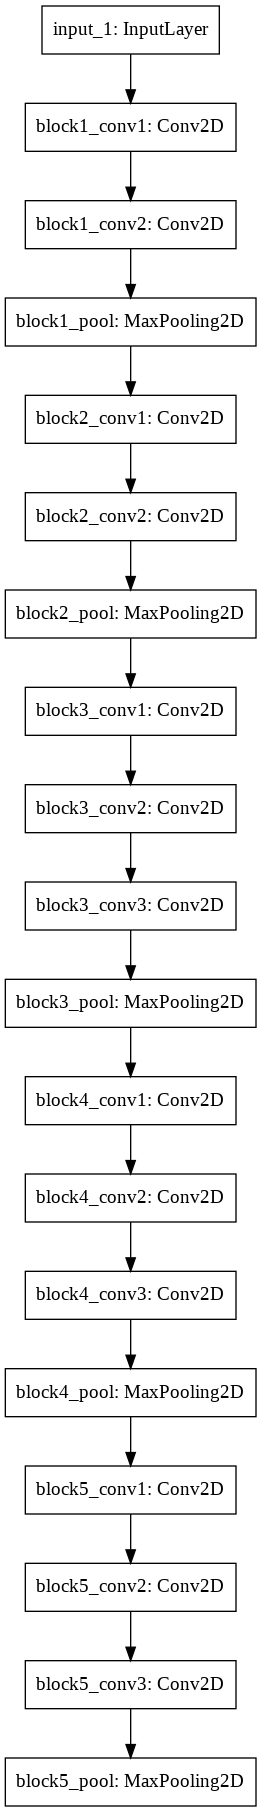

In [ ]:
tf.keras.utils.plot_model(encoder)

##Function to build the U-net model

In [ ]:
def build_model():
  inputs = tf.keras.Input(shape=X_train[0].shape)
  x = inputs
  skip_connections = encoder(x)
  x = skip_connections[-1]
  skip_connections = skip_connections[:-1]
  skip_connections.reverse()
  skip_connections = [skip_connections[i] for i in range(len(skip_connections)) if i % 2 == 0]
  
  for i in range(len(decoder_layers)):
      x = decoder_layers[i](x)
      concat = tf.keras.layers.Concatenate()
      x = concat([x, skip_connections[i]])
      

  last = tf.keras.layers.Convolution2DTranspose(23,3,strides=2,padding='same')
  x = last(x)
  model = tf.keras.Model(inputs=inputs, outputs=x)
  return model

##Display the model architecture

In [ ]:
segmentation_model = build_model()
segmentation_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 192, 320, 3) 0                                            
__________________________________________________________________________________________________
model_7 (Functional)            [(None, 192, 320, 64 14714688    input_28[0][0]                   
__________________________________________________________________________________________________
up_sampling2d_24 (UpSampling2D) (None, 12, 20, 512)  0           model_7[0][9]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 12, 20, 1024) 0           up_sampling2d_24[0][0]           
                                                                 model_7[0][8]              

Plot of the model architecture and skip connections

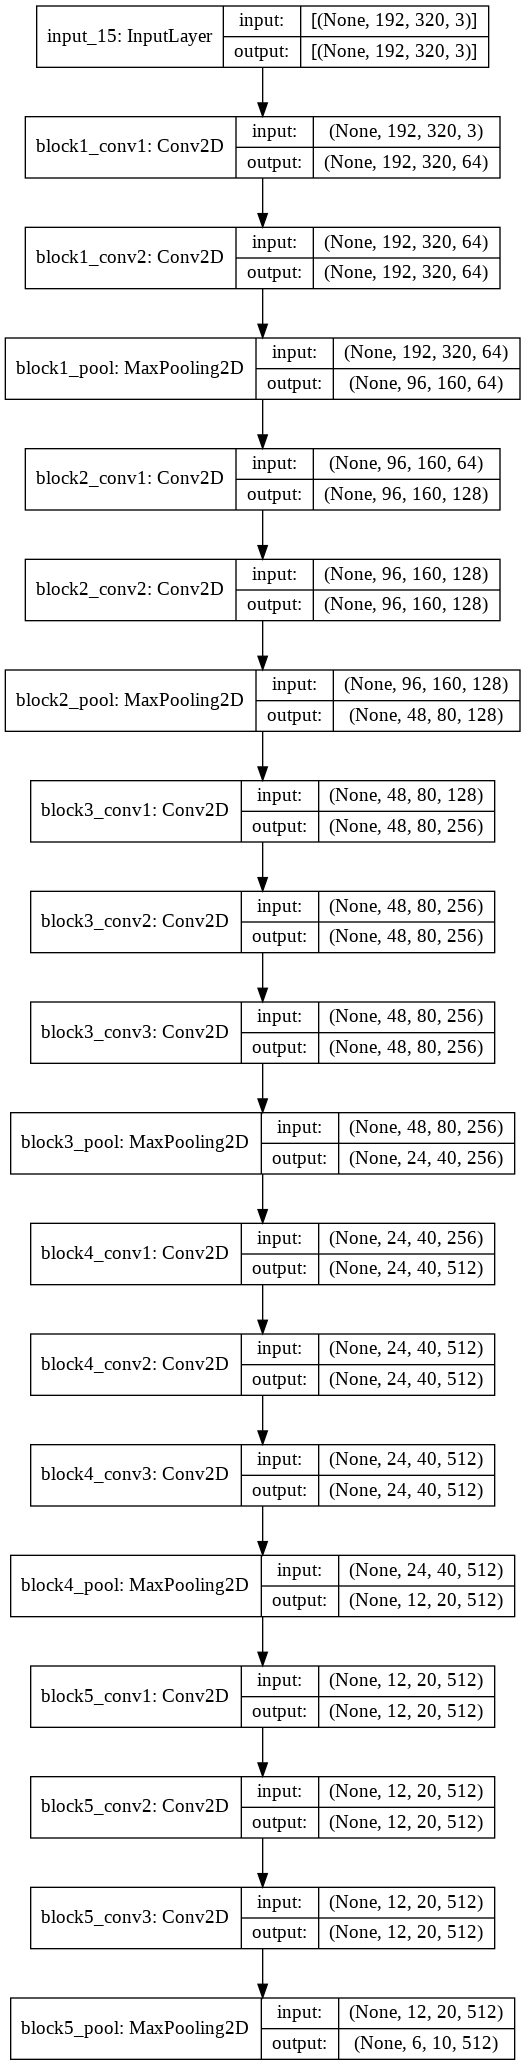

In [ ]:
tf.keras.utils.plot_model(encoder, show_shapes=True)

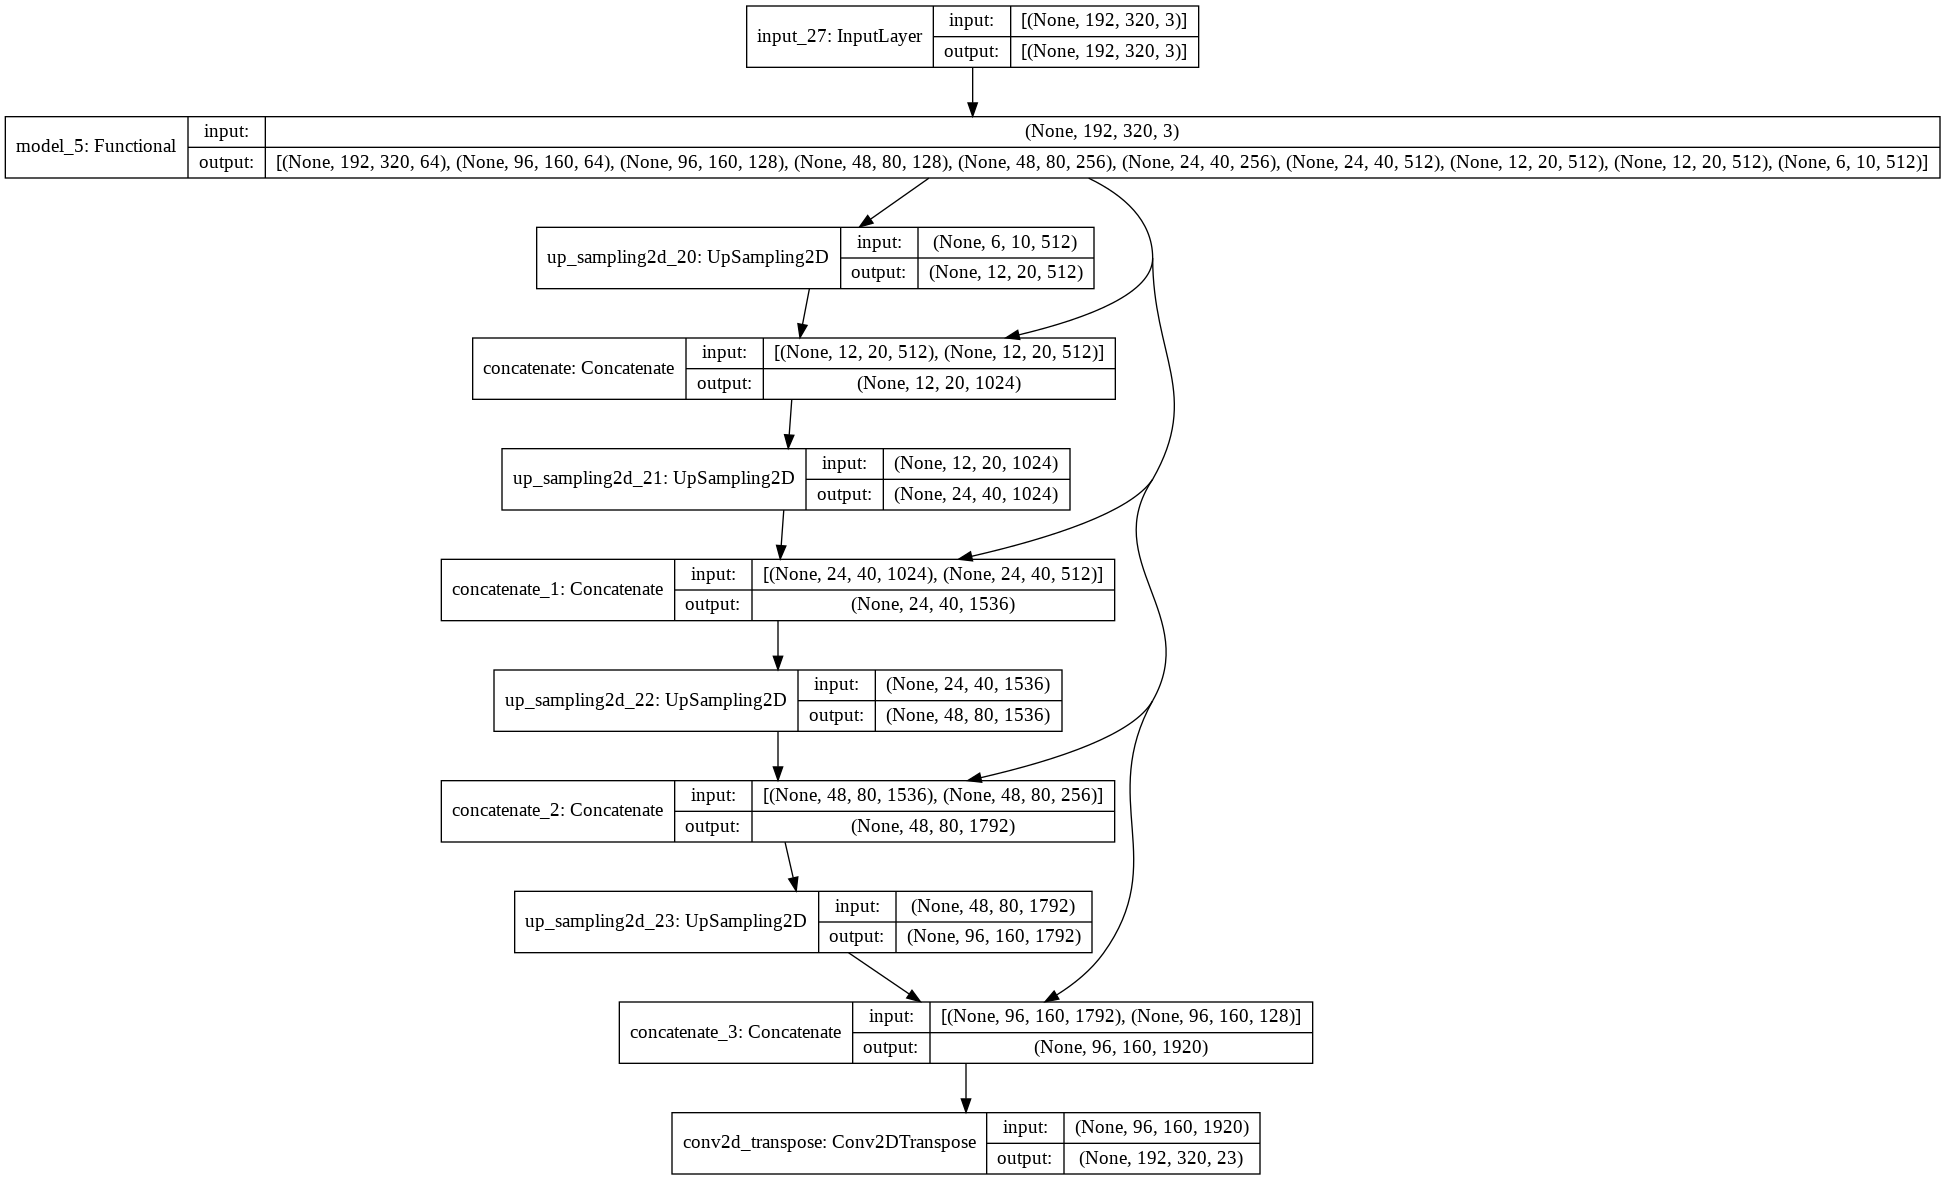

In [ ]:
tf.keras.utils.plot_model(segmentation_model, show_shapes=True)

Model compilation

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
segmentation_model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])

##Model Training

In [ ]:
hist = segmentation_model.fit(X_train, Y_train, batch_size=12, epochs=EPOCHS, validation_data=(X_val, Y_val), verbose=1)

Epoch 1/40
24/24 [==============================] - 67s 1s/step - loss: 2.3068 - accuracy: 0.3888 - val_loss: 1.9553 - val_accuracy: 0.4588
Epoch 2/40
24/24 [==============================] - 27s 1s/step - loss: 1.6903 - accuracy: 0.5218 - val_loss: 1.6190 - val_accuracy: 0.5162
Epoch 3/40
24/24 [==============================] - 27s 1s/step - loss: 1.4991 - accuracy: 0.5645 - val_loss: 1.5442 - val_accuracy: 0.5393
Epoch 4/40
24/24 [==============================] - 27s 1s/step - loss: 1.4646 - accuracy: 0.5728 - val_loss: 1.3759 - val_accuracy: 0.5959
Epoch 5/40
24/24 [==============================] - 27s 1s/step - loss: 1.3642 - accuracy: 0.5932 - val_loss: 1.3595 - val_accuracy: 0.5908
Epoch 6/40
24/24 [==============================] - 27s 1s/step - loss: 1.3135 - accuracy: 0.6041 - val_loss: 1.1877 - val_accuracy: 0.6383
Epoch 7/40
24/24 [==============================] - 27s 1s/step - loss: 1.1660 - accuracy: 0.6493 - val_loss: 1.0906 - val_accuracy: 0.6735
Epoch 8/40
24/24 [==

##Plot the learning curve of the model

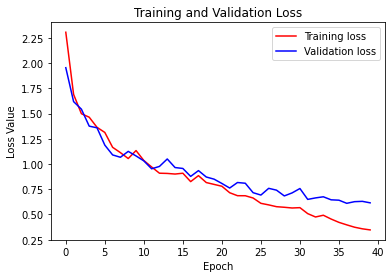

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

##Save model

In [ ]:
segmentation_model.save('/content/gdrive/Shareddrives/SEP_769/group2_vgg_segmentation-old.h5')

#Predictions on the test set and google maps images

##Load Model

In [10]:
model = None
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
model.summary()

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 192, 320, 3) 0                                            
__________________________________________________________________________________________________
model_23 (Functional)           [(None, 192, 320, 64 14714688    input_48[0][0]                   
__________________________________________________________________________________________________
up_sampling2d_87 (UpSampling2D) (None, 12, 20, 512)  0           model_23[0][9]                   
__________________________________________________________________________________________________
concatenate_90 (Concatenate)    (None, 12, 20, 1024) 0           up_sampling2d_87[0][0]           
                                                                 model_23[0][8]            

In [11]:
predictions = model.predict(x_test)


##Processing Network Outputs

In [17]:
predictions_processed = np.array([create_mask(predictions[i]) for i in range(len(predictions))])
print(predictions_processed.shape)
print(np.squeeze(predictions_processed).shape)
predictions_processed = np.squeeze(predictions_processed)

(5, 192, 320, 1)
(5, 192, 320)


##Display True labels and predicted labels of the test set

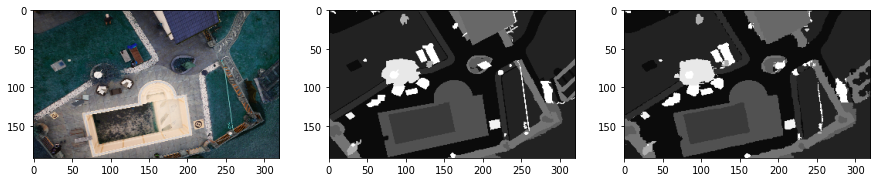

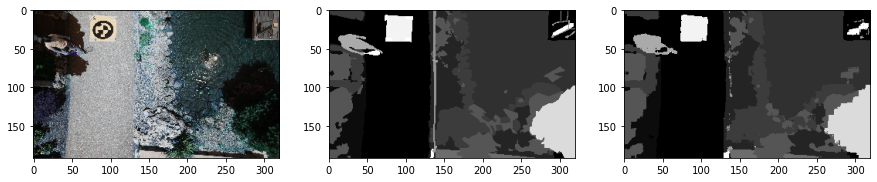

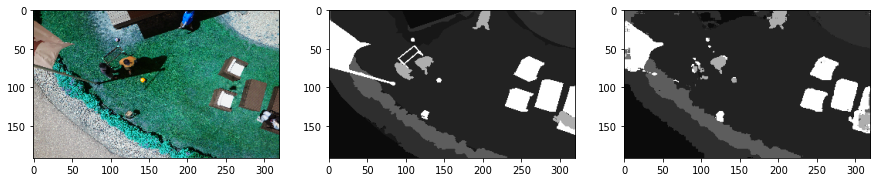

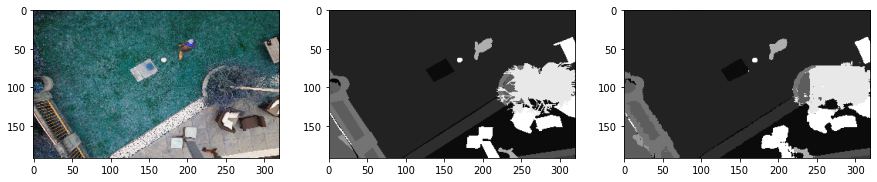

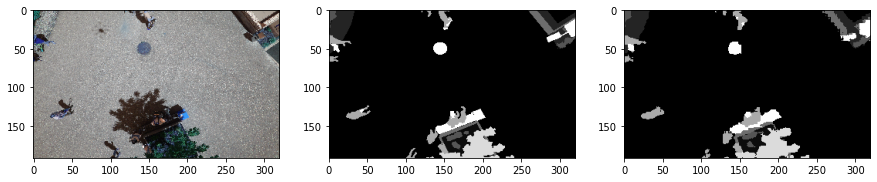

In [25]:
for i in range(5):
  display_images([x_test[i], y_test[i], predictions_processed[i]])

##Mean IOU

In [19]:
iou = tf.keras.metrics.MeanIoU(num_classes=23)
iou.update_state(y_test, predictions_processed)
iou.result().numpy()

0.58122355

##Pixel Accuracy

In [20]:
pixel_err = np.sum(predictions_processed != y_test)
print('Pixel Error: ', pixel_err)
pixel_accuracy = 1 - pixel_err / y_test.size
print(f'Pixel Accuracy: {round(pixel_accuracy * 100, 1)}%')

Pixel Error:  16730
Pixel Accuracy: 94.6%


##Load google maps images

In [22]:
gmaps_images = images_to_array(gmaps_images_path, width=WIDTH, height=HEIGHT, ext='PNG')
gmaps_images = gmaps_images / 255.0

Predict labels from google maps images

In [23]:
g_maps_predictions = model.predict(gmaps_images)
g_maps_predictions = np.array([create_mask(g_maps_predictions[i]) for i in range(len(g_maps_predictions))])
g_maps_predictions = np.squeeze(g_maps_predictions)
g_maps_predictions_colour = np.array([labels_to_colour(g_maps_predictions[i]) for i in range(len(g_maps_predictions))])
print(g_maps_predictions.shape)
print(g_maps_predictions_colour.shape)

(5, 192, 320)
(5, 192, 320, 3)


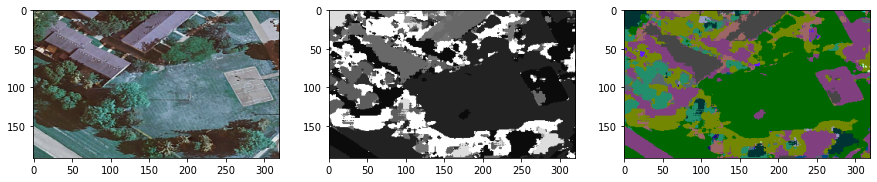

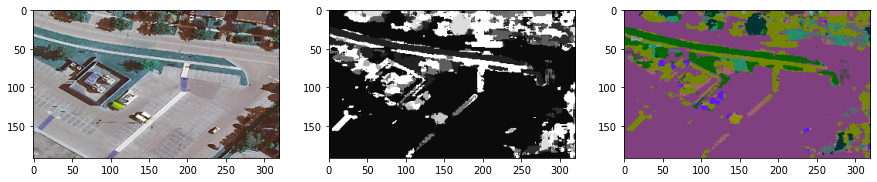

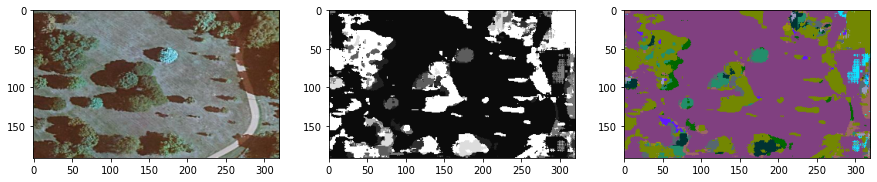

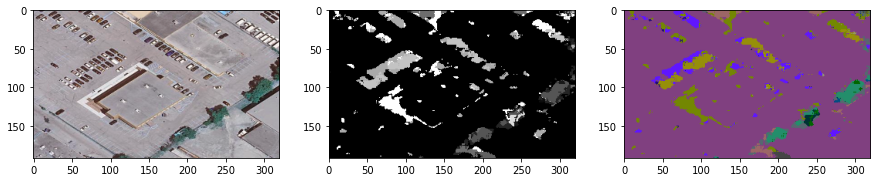

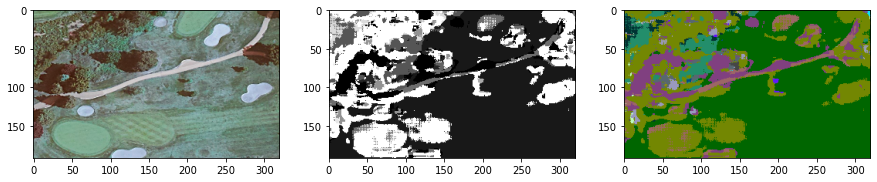

In [24]:
for i in range(len(gmaps_images)):
  display_images([gmaps_images[i],g_maps_predictions[i], g_maps_predictions_colour[i]])

# Collision Detection Algorithm

In [82]:
def find_danger_zones(img):
  if not 1 in img:
    return
  cars = np.where(img == 17, 255, 0)
  people = np.where(img == 15, 255, 0)
  car_contours, car_hierarchy = cv2.findContours(np.uint8(cars), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  car_contours = [contour for contour in car_contours if cv2.contourArea(contour) > 0]
  people_contours, people_hierarchy = cv2.findContours(np.uint8(people), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  people_contours = [contour for contour in people_contours if cv2.contourArea(contour) > 0]
  
  img_with_boxes = np.zeros((192,320,3))
  img_with_boxes[:,:,0] = img
  img_with_boxes[:,:,1] = img
  img_with_boxes[:,:,2] = img

  danger_threshold = 320 / 5
  car_boxes = []
  people_boxes = []
  hazard_count = 0

  for cont in car_contours:
    x,y,w,h = cv2.boundingRect(cont)
    cv2.rectangle(img_with_boxes,(x,y),(x+w,y+h),(0,255,0),2)
    car_boxes.append((x,y,w,h))
  
  for cont in people_contours:
    x,y,w,h = cv2.boundingRect(cont)
    cv2.rectangle(img_with_boxes,(x,y),(x+w,y+h),(255,0,0),2)
    people_boxes.append((x,y,w,h))

  # checks if there is more than 1 car
  # if not, returns nothing from the function
  if len(car_boxes) < 2:
    print("No area flagged - not enough cars detected\n")
    return 
  
  for car in car_boxes:
    # gets the center point of the cars bounding box
    car_cx = car[0] + (car[2]/2)
    car_cy = car[1] + (car[3]/2)
    # cv2.circle(img_with_boxes, (int(car_cx),int(car_cy)), radius=0, color=(0, 0, 255), thickness=-1)
    for person in people_boxes:
      # gets the center point for the persons bounding box
      person_cx = person[0] + (person[2] / 2)
      person_cy = person[1] + (person[3] / 2)
      # computes distance (pixel) between the center of the car bounding box and the person bounding box
      distance = math.sqrt(((person_cx - car_cx)**2) + ((person_cy - car_cy)**2))
      if distance < danger_threshold:
        cv2.line(img_with_boxes, (int(car_cx), int(car_cy)), (int(person_cx), int(person_cy)), (0,0,255), thickness=1)
        hazard_count += 1
  
  cv2_imshow(img_with_boxes)
  if hazard_count >= 3:
    print("Area flagged - potentially hazardous for pedestrians\n")
  else:
    print("No area flagged - hazard threshold not met\n")
  #return img_with_boxes

# Checking for possible collisions in an image

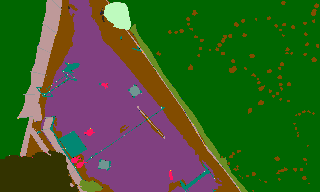

No area flagged - not enough cars detected



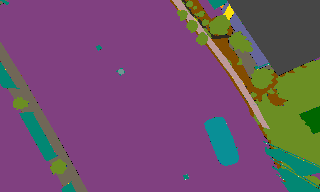

No area flagged - not enough cars detected



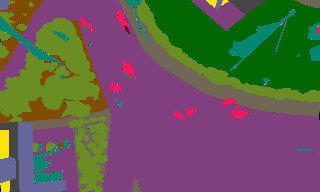

No area flagged - not enough cars detected



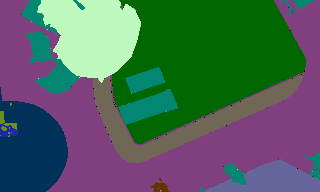

No area flagged - not enough cars detected



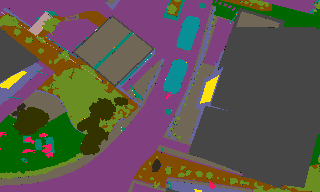

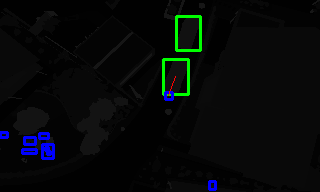

No area flagged - hazard threshold not met



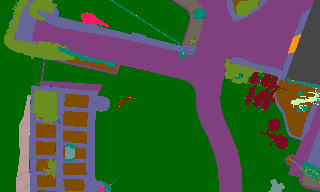

No area flagged - not enough cars detected



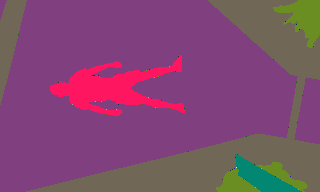

No area flagged - not enough cars detected



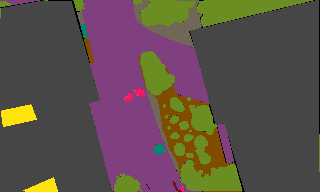

No area flagged - not enough cars detected



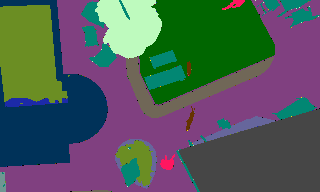

No area flagged - not enough cars detected



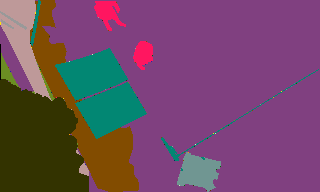

No area flagged - not enough cars detected



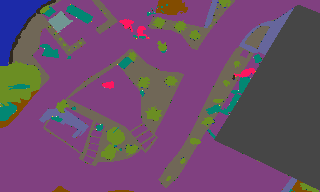

No area flagged - not enough cars detected



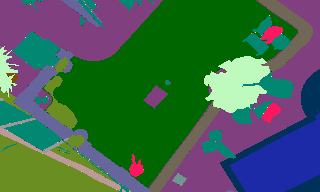

No area flagged - not enough cars detected



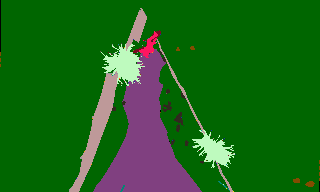

No area flagged - not enough cars detected



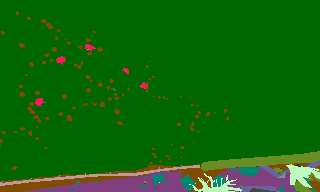

No area flagged - not enough cars detected



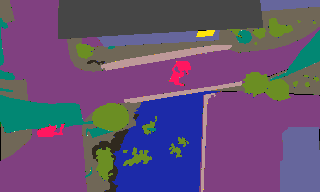

No area flagged - not enough cars detected



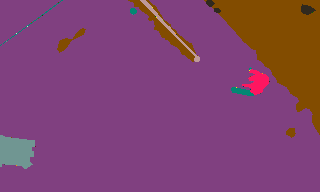

No area flagged - not enough cars detected



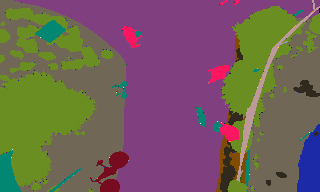

No area flagged - not enough cars detected



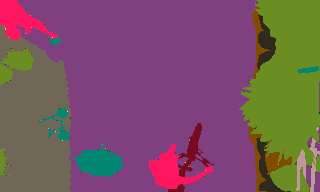

No area flagged - not enough cars detected



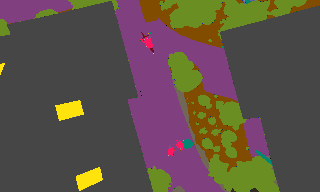

No area flagged - not enough cars detected



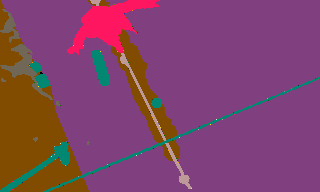

No area flagged - not enough cars detected



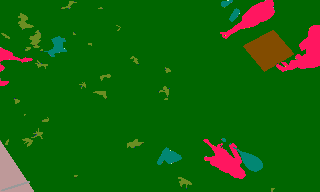

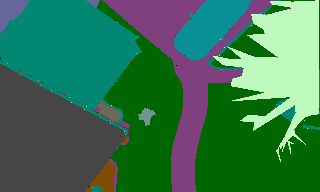

No area flagged - not enough cars detected



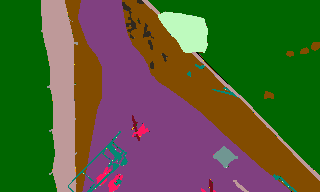

No area flagged - not enough cars detected



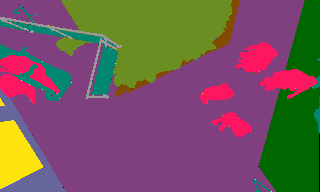

No area flagged - not enough cars detected



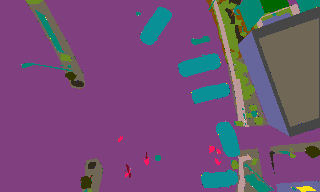

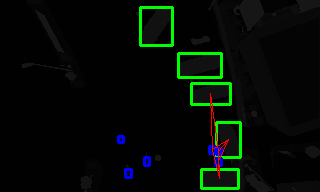

Area flagged - potentially hazardous for pedestrians



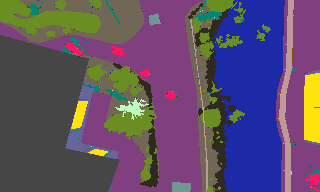

No area flagged - not enough cars detected



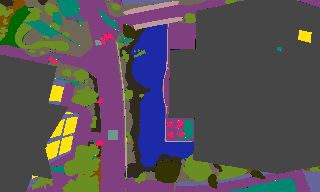

No area flagged - not enough cars detected



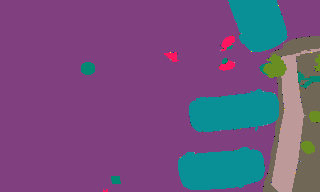

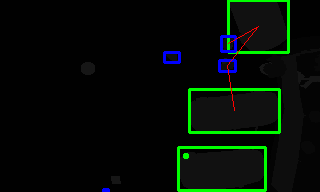

Area flagged - potentially hazardous for pedestrians



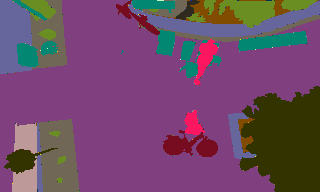

No area flagged - not enough cars detected



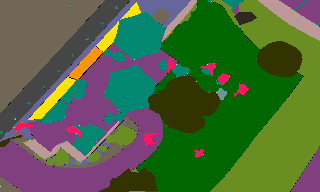

No area flagged - not enough cars detected



In [83]:
for i in range(30):
  cv2_imshow(labels_to_colour(y_test[i]))
  find_danger_zones(y_test[i])

# Running Final Model

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Imported images shape:  (10, 192, 320, 3)
Imported labels shape:  (10, 192, 320)


Results from Drone Images:



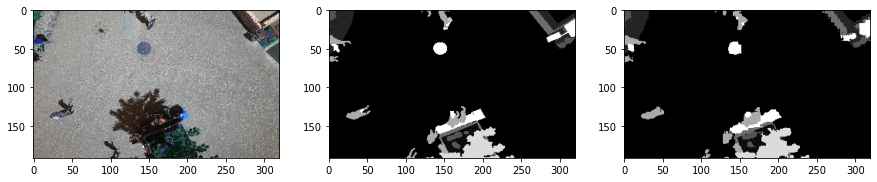

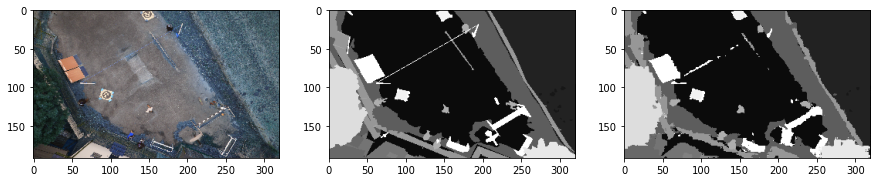

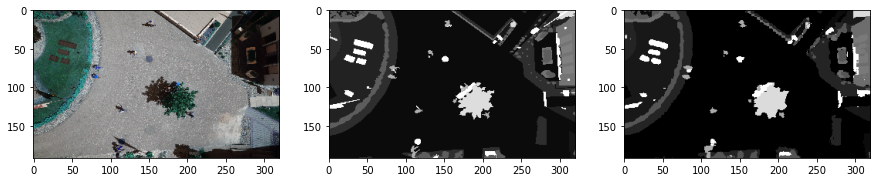

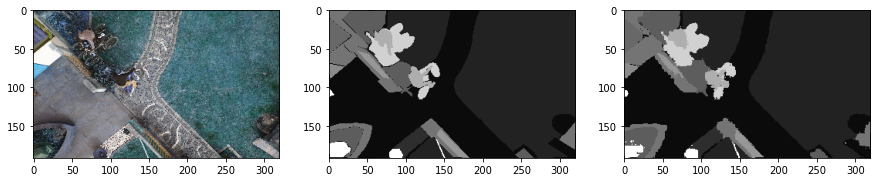

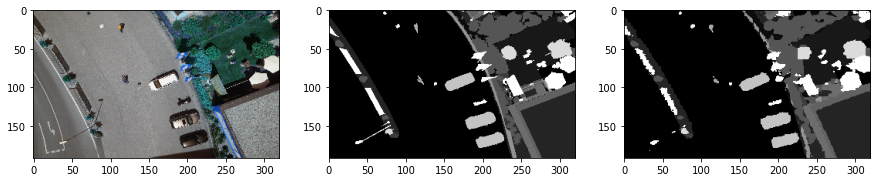



Metrics for Drone Images
IOU Result = 0.5858232975006104
Pixel Error Result = 54733
Pixel Accuracy: 91.1%




Results from Google Images:



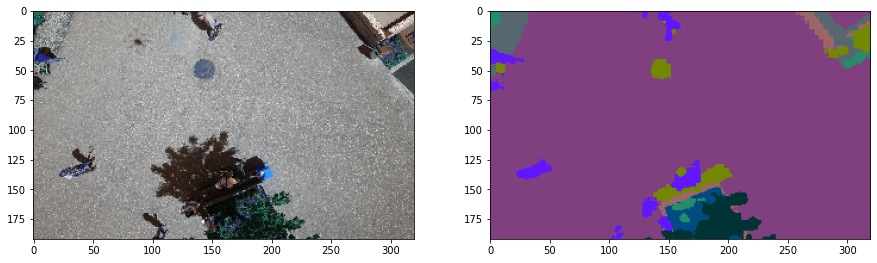

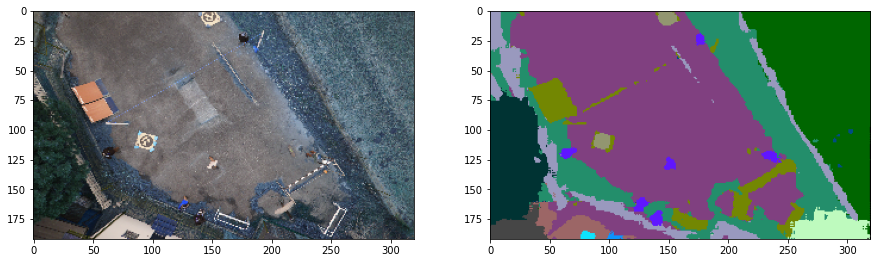

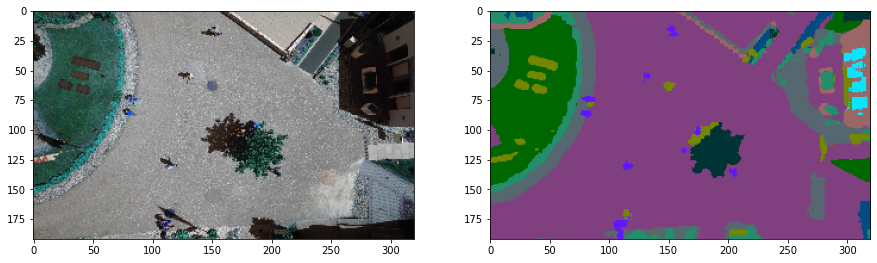

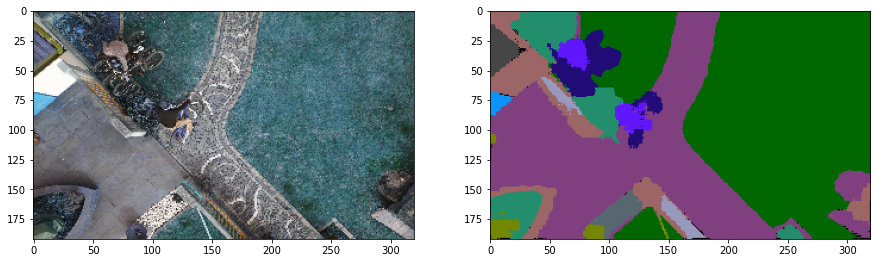

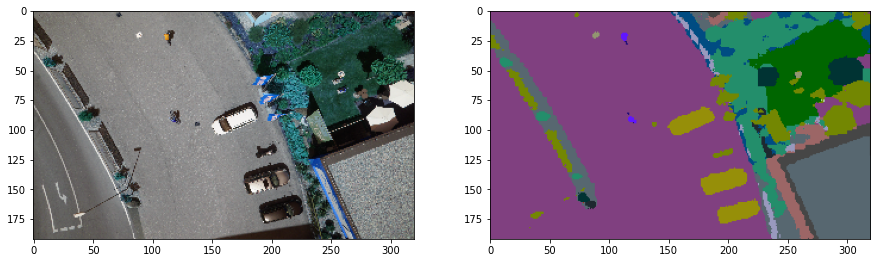



Examples For Collision Detection:



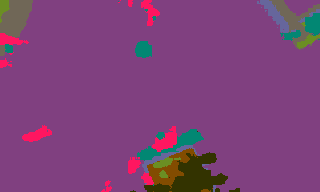

No area flagged - not enough cars detected



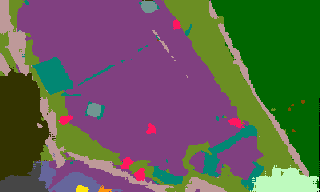

No area flagged - not enough cars detected



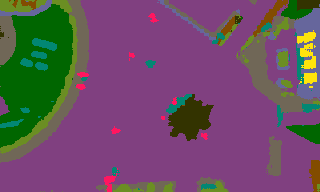

No area flagged - not enough cars detected



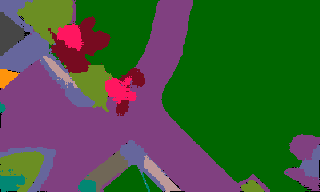

No area flagged - not enough cars detected



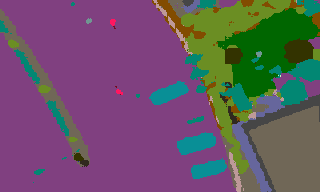

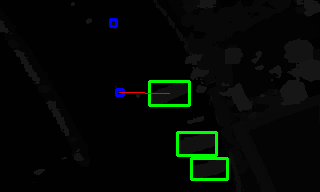

No area flagged - hazard threshold not met



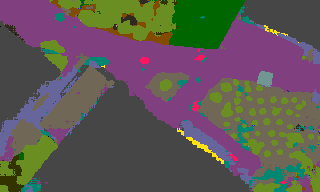

No area flagged - not enough cars detected



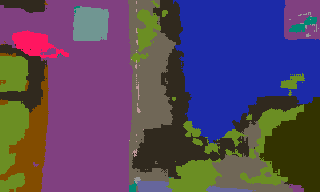

No area flagged - not enough cars detected



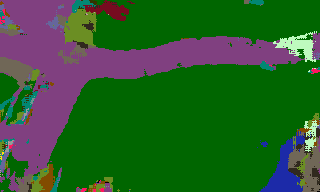

No area flagged - not enough cars detected



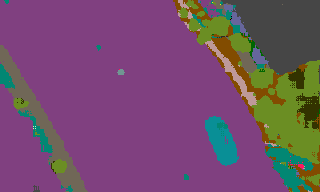

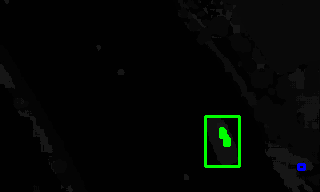

No area flagged - hazard threshold not met



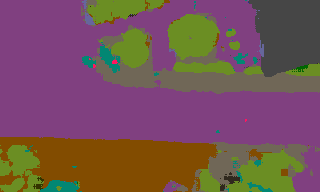

No area flagged - not enough cars detected



In [14]:
#FINAL SUBMISSION:
import tensorflow as tf
from google.colab.patches import cv2_imshow

#FINAL SUBMISSION:
from google.colab import drive
import tensorflow as tf
import tensorflow_datasets as tfds
drive.mount('/content/gdrive')
import cv2
import glob
import numpy as np
import pandas as pd
import os
import fnmatch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import math


#FUNCTIONS AND CONSTANTS
original_images_path = '/content/gdrive/Shareddrives/SEP_769/SEP_769/data/drone_data/original_images/'
original_semantic_path = '/content/gdrive/Shareddrives/SEP_769/SEP_769/data/drone_data/label_images_semantic/'
colourmap_path = "/content/gdrive/Shareddrives/SEP_769/SEP_769/class_dict_seg.csv"
rgb_masks_path = "/content/gdrive/Shareddrives/SEP_769/SEP_769/RGB_color_image_masks/RGB_color_image_masks/"
model_path = '/content/gdrive/Shareddrives/SEP_769/SEP_769/group2_vgg_segmentation.h5'
gmaps_images_path = '/content/gdrive/Shareddrives/SEP_769/SEP_769/google_maps_imgs/'

HEIGHT = 192
WIDTH = 320








#Reads all images from dir (unless num is specified), resizes and returns np array
def images_to_array(dir, width, height, ext='.jpg', num=0):
  data = []
  files = os.listdir(dir)
  files.sort()
  if num:
    for i in range(num):
      filename = files[i]
      if filename.endswith(ext):
        img = cv2.imread(dir+filename,flags=1)
        img = cv2.resize(img, (width, height))
        data.append(img)
  else:
    for filename in files:
      if filename.endswith(ext):
        img = cv2.imread(dir+filename,flags=1)
        img = cv2.resize(img, (width, height))
        data.append(img)
  return np.array(data)
#Plot provided images

def display_images(images):
  plt.figure(figsize=(15,10))
  for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    if len(images[i].shape) == 3:
      plt.imshow(images[i])
    else:
      plt.imshow(images[i], cmap="gray")
  plt.show()

#Convert segmentation masks from grayscale to RGB with colourmap
def labels_to_colour(label):
  colourmap = pd.read_csv(colourmap_path)
  red = np.zeros((192,320))
  green = np.zeros((192,320))
  blue = np.zeros((192,320))
  for i in range(len(label)):
    for j in range(len(label[i])):
      red[i:i+1,j:j+1] = colourmap[" r"][label[i][j]]
      green[i:i+1,j:j+1] = colourmap[" g"][label[i][j]]
      blue[i:i+1,j:j+1] = colourmap[" b"][label[i][j]]
  result = np.dstack((blue,green,red))
  return result

#Convert model outputs into single channel segmentation mask
def create_mask(pred):
  mask = np.argmax(pred, axis=-1)
  mask = mask[..., np.newaxis]
  return mask

#Prediction With Masks for Metrics
def performance_test(images, labels, model):
  predictions = model.predict(images)
  predictions_processed = np.array([create_mask(predictions[i]) for i in range(len(predictions))])
  predictions_processed = np.squeeze(predictions_processed)

  #Display first 5 true labels and predicted labels
  for i in range(5):
    display_images([images[i], labels[i], predictions_processed[i]])

  #Metrics using provided labels
  iou = tf.keras.metrics.MeanIoU(num_classes=23)
  iou.update_state(labels, predictions_processed)
  iou_result = iou.result().numpy()
  pixel_err = np.sum(predictions_processed != labels)
  pixel_accuracy = 1 - pixel_err / labels.size

  return predictions_processed, iou_result, pixel_err, pixel_accuracy

#Returns predictions for images as colour rgb segmentation mask
def color_predictions(images, model):
  predictions = model.predict(images)
  predictions_processed = np.array([create_mask(predictions[i]) for i in range(len(predictions))])
  predictions_processed = np.squeeze(predictions_processed)
  predictions_processed = np.array([labels_to_colour(predictions_processed[i]).astype(int) for i in range(len(predictions_processed))])

  #Display first 5 images and predicted masks
  for i in range(5):
    display_images([images[i], predictions_processed[i]])

  return predictions_processed

def find_danger_zones(img):
  if not 1 in img:
    return
  cars = np.where(img == 17, 255, 0)
  people = np.where(img == 15, 255, 0)
  car_contours, car_hierarchy = cv2.findContours(np.uint8(cars), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  car_contours = [contour for contour in car_contours if cv2.contourArea(contour) > 0]
  people_contours, people_hierarchy = cv2.findContours(np.uint8(people), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  people_contours = [contour for contour in people_contours if cv2.contourArea(contour) > 0]
  
  img_with_boxes = np.zeros((192,320,3))
  img_with_boxes[:,:,0] = img
  img_with_boxes[:,:,1] = img
  img_with_boxes[:,:,2] = img

  danger_threshold = 320 / 5
  car_boxes = []
  people_boxes = []
  hazard_count = 0

  for cont in car_contours:
    x,y,w,h = cv2.boundingRect(cont)
    cv2.rectangle(img_with_boxes,(x,y),(x+w,y+h),(0,255,0),2)
    car_boxes.append((x,y,w,h))
  
  for cont in people_contours:
    x,y,w,h = cv2.boundingRect(cont)
    cv2.rectangle(img_with_boxes,(x,y),(x+w,y+h),(255,0,0),2)
    people_boxes.append((x,y,w,h))

  # checks if there is more than 1 car
  # if not, returns nothing from the function
  if len(car_boxes) < 2:
    print("No area flagged - not enough cars detected\n")
    return 
  
  for car in car_boxes:
    # gets the center point of the cars bounding box
    car_cx = car[0] + (car[2]/2)
    car_cy = car[1] + (car[3]/2)
    # cv2.circle(img_with_boxes, (int(car_cx),int(car_cy)), radius=0, color=(0, 0, 255), thickness=-1)
    for person in people_boxes:
      # gets the center point for the persons bounding box
      person_cx = person[0] + (person[2] / 2)
      person_cy = person[1] + (person[3] / 2)
      # computes distance (pixel) between the center of the car bounding box and the person bounding box
      distance = math.sqrt(((person_cx - car_cx)**2) + ((person_cy - car_cy)**2))
      if distance < danger_threshold:
        cv2.line(img_with_boxes, (int(car_cx), int(car_cy)), (int(person_cx), int(person_cy)), (0,0,255), thickness=1)
        hazard_count += 1
  
  cv2_imshow(img_with_boxes)
  if hazard_count >= 3:
    print("Area flagged - potentially hazardous for pedestrians\n")
  else:
    print("No area flagged - hazard threshold not met\n")
  #return img_with_boxes

#LOAD TRAINED MODEL
model = None
if os.path.exists(model_path):
  model = tf.keras.models.load_model(model_path)
#model.summary()


#IMPORTING DRONE IMAGES
images_original = images_to_array(original_images_path, width=WIDTH, height=HEIGHT, num=10)
images = images_original / 255
print('Imported images shape: ', images.shape)
labels = images_to_array(original_semantic_path, width=WIDTH, height=HEIGHT, ext='png', num=10)
labels = labels[:,:,:,1]
print('Imported labels shape: ', labels.shape)
rgb_masks = images_to_array(rgb_masks_path, width=WIDTH, height=HEIGHT, ext='png', num=10)


#Running Model performance test on drone images
print('\n\nResults from Drone Images:\n')
predictions_drone, iou_result, pixel_err, pixel_accuracy = performance_test(images, labels, model)
print('\n\nMetrics for Drone Images')
print('IOU Result = {}'.format(iou_result))
print('Pixel Error Result = {}'.format(pixel_err))
print(f'Pixel Accuracy: {round(pixel_accuracy * 100, 1)}%\n\n')

#IMPORTING GOOGLE MAPS IMAGES
images_g = images_to_array(gmaps_images_path, width=WIDTH, height=HEIGHT, ext='PNG')
images_g = images_g / 255



print('\n\nResults from Google Images:\n')
#Getting predictions for Google Maps iImages
predictions = color_predictions(images, model)

print('\n\nExamples For Collision Detection:\n')
for i in range(10):
  cv2_imshow(labels_to_colour(predictions_drone[i]))
  find_danger_zones(predictions_drone[i])
